# Genetic algorithm for portfolio optimization

<ul style="list-style-type:none;">
    <li>1. Introduction</li>
    <li>2. Data load and preparation</li>
    <li>3. Genetic algorithm setings</li>
    <li>4. Results and conclusions</li>
</ul>

### 1. Introduction

#### Portfolio theory

A portfolio is a collection of financial investments like stocks, bonds, commodities, cash, and cash equivalents. A portfolio may contain a wide range of assets including real estate, art, and private investments. 

One of the key concepts in portfolio management is the diversification of assets. Diversification tries to reduce risk by allocating investments among various financial instruments, industries, and other categories. It aims to maximize returns by investing in different areas that would each react differently to the same event. Uncorrelated assets or assets with low correlation are very useful for diversification, because correlation contributes to the calculation of risk, and if you have low assets correlation it help to reduce risk. 

An investment portfolio is a partition of the total capital, this partition defines the portion of the capital to be alocated at each asset, this proportion of assets are called the weights of the portfolio, and the election of assets and weights determine the expected return of the portfolio and the risk associated to it. Investors aim to construct a well-diversified portfolio to achieve a risk-return portfolio allocation that is appropriate for their level of risk tolerance. Your goals for the future, your appetite for risk, and your personality are all factors in deciding how to build your portfolio and how to determine the weights.

#### Portfolio optimization

Portfolio optimization is the process of selecting the best portfolio posible out of all posible portfolios acording to some objectives of expected returns, aversion of risk and available capital. The portfolio optimization problem is specified as a constrained utility-maximization problem. Common formulations of portfolio utility functions define it as the expected portfolio return (net of transaction and financing costs) minus a cost of risk.

Central to this optimization is the construction of the covariance matrix for the rates of return on the assets in the portfolio. Some of the most used portfolio optimization techniques are:

<ul style="list-style-type:none;">
    <li>Linear and non-linear programming</li>
    <li>Stochastic programming</li>
    <li>Meta-heuristic methods</li>
    <li>Principal component-based methods</li>
    <li>Genetic algorithms</li>
</ul>

#### Genetic algorithms

A genetic algorithm is a search heuristic that is inspired by Charles Darwin’s theory of natural evolution. This algorithm reflects the process of natural selection where the fittest individuals are selected for reproduction in order to produce offspring of the next generation.

Notion of Natural Selection

The process of natural selection starts with the selection of fittest individuals from a population. They produce offspring which inherit the characteristics of the parents and will be added to the next generation. If parents have better fitness, their offspring will be better than parents and have a better chance at surviving. This process keeps on iterating and at the end, a generation with the fittest individuals will be found.

This notion can be applied for a search problem. We consider a set of solutions for a problem and select the set of best ones out of them. Five phases are considered in a genetic algorithm.

Initial population.- In this case the initial population are constructed all weights at random.

Fitness function.- The fitness function assigns a probability to be selected depend on the value of the spected return or volatility. High expected return or low volatility leads to a high probability of being selected.

Selection.- After assing a probability of being selected, a random number determines which portfolio of the population will pass to the next generation.

Crossover.- The elements selected are object to a crossover process at which some of the weight are combine with the weights of another elemnt of the selected population.

Mutation.- Finally some little changes are apply to the next generation population in order to have variety at the population.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import os
import random
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
def period(start, end, distance = 1):
    s = start.split('-')
    e = end.split('-')
    y1 = int(s[0])
    m1 = int(s[1])
    d1 = int(s[2])
    y2 = int(e[0])
    m2 = int(e[1])
    d2 = int(e[2])
    dates = []
    dates.append(start)
    while((y1 < y2) or (y1 == y2 and m1 < m2) or (y1 == y2 and m1 == m2 and d1 <= d2 - distance)):
        if(np.isin(m1, [1,3,5,7,8,10])):
            d1 += distance
            if(d1 > 31):
                d1 = d1%31
                m1 += 1
        elif(m1 == 12):
            d1 += distance
            if(d1 > 31):
                d1 = d1%31
                m1 = 1
                y1 += 1
        elif(np.isin(m1, [4,6,9,11])):
            d1 += distance
            if(d1 > 30):
                d1 = d1%30
                m1 += 1
        elif(m1 == 2):
            d1 += distance
            if((y1/4 - math.floor(y1/4)) == 0):
                if(d1 > 29):
                    d1 = d1%29
                    m1 += 1
            else:
                if(d1 > 28):
                    d1 = d1%28
                    m1 += 1
        else:
            print("Error: month > 12")
        dates.append(str(y1)+'-'+str(m1)+'-'+str(d1))
        df = pd.DataFrame(dates,columns=['Date'])
        df['Date'] =  pd.to_datetime(df['Date'], format='%Y-%m-%d')
        df = df.set_index(['Date'])
        #df = pd.to_datetime(df)
    return df
def month_list(start_date,end_date):
    start_d = start_date.split('-')[2]
    start_m = start_date.split('-')[1]
    start_y = start_date.split('-')[0]
    end_d = end_date.split('-')[2]
    end_m = end_date.split('-')[1]
    end_y = end_date.split('-')[0]
    n_months = ((int(end_y) - int(start_y))*12) + ((int(end_m) - int(start_m)))
    months = []
    y = int(start_y)
    for i in range(n_months):
        m = ((int(start_m) - 1 + i)%12) + 1
        if(((int(start_m)-1 + i)%12) == 0 and i != 0):
            y += 1 
        date = str(y) + '-' + str(m) + '-' + str(1)
        months.append(date)
    months = pd.DataFrame(months, columns=['Date'])
    months['Date'] =  pd.to_datetime(months['Date'], format='%Y-%m-%d')
    months = months.set_index(['Date'])
    return months

def load_table(path, dvd = True):
    files = os.listdir(path)
    df_list = list()
    for i in range(len(files)):
        table = pd.read_csv(path+files[i],index_col='Date',parse_dates=True)[['Close']]
        name = files[i].replace(".csv","")
        table.columns = [name]
        df_list.append(table)
    df = df_list[0]
    for df_ in df_list[1:]:
        df = pd.concat([df,df_], axis=1)
    df.fillna(method='ffill',inplace=True)
    return df_list, df

def monthly_returns(price, start_date, end_date):
    months = month_list(start_date,end_date)
    returns_df = pd.DataFrame(months.index,columns=['Date'])
    for col in price.columns:
        values = []
        for i in range(len(months)-1):
            idx = price.loc[(price.index >= months.index[i]) & (price.index < months.index[i+1])].index
            v = price.loc[idx,col].iloc[0]
            values = np.append(values,v)
            values = pd.DataFrame(values,columns=[col])
        returns_df = pd.concat([returns_df,values],axis=1)
    returns_df.drop(len(months)-1,axis=0,inplace=True)
    returns_df = returns_df.set_index("Date")
    returns = returns_df.pct_change()*100
    returns = returns.drop(returns.index[0], axis=0)
    return returns_df

def tree_to_table(tree, name_str):
    n_gen = len(tree)
    n_chrom = len(tree[0])
    name = []
    gen = []
    chrom = []
    ret = []
    vol = []
    sr = []
    res = []
    for i in range(n_gen):
        for j in range(n_chrom):
            name.append(name_str)
            gen.append(i)
            chrom.append(j)
            ret.append(tree[i][j].get_expected_return())
            vol.append(tree[i][j].get_volatility())
            sr.append(tree[i][j].get_sharpe_ratio())
    d = {'name': name, 'generation': gen, 'chromosome': chrom, 'return': ret, 'volatility': vol, 'sharpe_ratio': sr}
    df = pd.DataFrame(data=d)
    return df

In [3]:
class Portfolio:
    def __init__(self, returns_df, corr_matrix, risk_free):
        self.returns = returns_df
        self.corr = corr_matrix
        self.description = self.returns.describe()
        self.n_assets = self.returns.shape[1]
        self.risk_free = risk_free
        self.initialize_weights()
        self.set_expected_return()
        self.set_volatility()
        self.set_sharpe_ratio()
        return None
    def initialize_weights(self):
        self.weights = np.random.rand(self.n_assets)
        self.weights = (self.weights/self.weights.sum())
        return None
    def set_weights(self, weights):
        self.weights = (weights/weights.sum())
        self.set_discrete_weights = self.weights
        return None
    def set_expected_return(self):
        weighted = self.weights*self.description.loc['mean']
        self.expected_return = weighted.sum().round(2)
        return None
    def set_volatility(self):
        std = self.description.loc['std'].values
        m1 = (self.weights*std).reshape(self.n_assets,1)
        m2 = m1.reshape(1,self.n_assets)
        self.volatility = math.sqrt((m1*self.corr*m2).sum())
        return None
    def set_sharpe_ratio(self):
        self.sharpe_ratio = (self.expected_return-self.risk_free)/self.volatility
        return None
    def get_weights(self):
        return self.weights
    def get_expected_return(self):
        return self.expected_return
    def get_volatility(self):
        return self.volatility
    def get_sharpe_ratio(self):
        return self.sharpe_ratio

In [4]:
class Genetic_algorithm:
    def __init__(self, returns_df, corr_matrix, risk_free, size):
        self.returns = returns_df
        self.corr = corr_matrix
        self.risk_free = risk_free
        self.size = size
        return None
    def run(self, iterations, variable):
        self.initialize()
        for i in range(iterations):
            self.set_fitness(variable)
            self.select_fittest()
            self.crossover()
            self.mutation()
            self.pass_generation(variable)
        return None
    def initialize(self):
        self.population = []
        self.offspring = []
        self.population_best = []
        self.population_fitness = []
        self.population_mean  = []
        self.tree = list()
        for i in range(self.size):
            self.population.append(Portfolio(self.returns, self.corr, self.risk_free))
        self.population_df = self.to_table(self.population)
        self.tree.append(self.population)
        return None
    def set_fitness(self, variable):
        if(variable == 'volatility'):
            max_volatility = self.population_df[variable].max()
            self.population_df.sort_values(by=variable, inplace=True, ascending=True)
            self.population_df['fitness'] = max_volatility - self.population_df[variable] + 1
            self.population_df['fitness'] = self.population_df['fitness']/self.population_df['fitness'].sum()
        else:
            self.population_df.sort_values(by=variable, inplace=True, ascending=False)
            self.population_df['fitness'] = self.population_df[variable]/self.population_df[variable].sum()
        self.population_df['selection_prob'] = self.population_df['fitness']
        for i in range(1, len(self.population_df['selection_prob'])):
            self.population_df['selection_prob'].iloc[i] = self.population_df['selection_prob'].iloc[i-1] + self.population_df['selection_prob'].iloc[i]
        return self.population_df
    def select_fittest(self, rand = True):
        third = int(self.size/3)
        idx = self.population_df.head(third).index.values
        if(rand == True):
            for i in idx:
                self.offspring.append(self.population[i])
                p = Portfolio(self.returns, self.corr, self.risk_free)
                self.offspring.append(p)
        else:
            for i in idx:
                self.offspring.append(self.population[i])
        return None
    def crossover(self):
        rest = self.size - len(self.offspring)
        for i in range(rest):
            idx_parent1 = self.select_parent()
            idx_parent2 = self.select_parent()
            alpha = random.random()
            w3 = alpha*self.population[idx_parent1].get_weights() + (1-alpha)*self.population[idx_parent2].get_weights()
            p = Portfolio(self.returns, self.corr, self.risk_free)
            p.set_weights(w3)
            self.offspring.append(p)
        return None
    def mutation(self):
        n_assets = len(self.population[0].get_weights())
        for child in self.offspring:
            idx1 = random.randrange(0,n_assets)
            idx2 = random.randrange(0,n_assets)
            w = child.get_weights()
            minimo = min(w[idx1],w[idx2])
            rand = random.uniform(0,minimo)
            w[idx1] += rand
            w[idx2] -= rand
            child.set_weights(w)
        return None
    def pass_generation(self, variable):
        self.population = self.offspring
        self.offspring = []
        self.population_df = self.to_table(self.population)
        self.tree.append(self.population)
        best = self.population[0]
        mean_fit = self.population_df[variable].mean()
        if(variable == 'volatility'):
            max_fit = self.population_df.sort_values(by=variable, ascending=True).head(1)[variable].iloc[0]
        else:
            max_fit = self.population_df.sort_values(by=variable, ascending=False).head(1)[variable].iloc[0]
        self.population_best.append(best)
        self.population_fitness.append(max_fit)
        self.population_mean.append(mean_fit)
        return None
    def select_parent(self):
        roulette = random.random()
        i = 0
        while roulette > self.population_df['selection_prob'].iloc[i]: 
            i += 1
        if(i > 0):
            i = i - 1
        return self.population_df.iloc[i,:].name
    def to_table(self, array):
        exp_returns = [s.get_expected_return() for s in array]
        volatilities = [s.get_volatility() for s in array]
        sharpe_ratios = [s.get_sharpe_ratio() for s in array]
        d = {'return': exp_returns, 'volatility': volatilities, 'sharpe_ratio' : sharpe_ratios}
        df = pd.DataFrame(data=d) 
        return df
    def get_samples(self):
        return self.samples
    def get_population(self,variable):
        self.population_df.sort_values(by=variable, inplace=True, ascending=False)
        idx = self.population_df.head(1).index.values[0]
        return self.population[idx]
    def get_tree(self, variable):
        return self.tree
    def get_analysis(self):
        d = {'best_fitness':self.population_fitness,'fitness_mean':self.population_mean}
        output = pd.DataFrame(data=d) 
        return output

## 2. Data load and preparation

First we set the date period to be analyzed and the stocks of the portfolio. In this example we select the stocks of Apple, Adobe, Amazon, Facebook, Microsoft, Nvidia, Qualcomm, Tesla, Texas instruments and for diversification Bitcon, Gold and the 13 Week Treasury Bil. We choose a period of two years between the first of june of 2019 and the first of july of 2021 with a month periodicty.

Then we load the historical prices and calculate the monthly returns, and correlation matrix.

In [5]:
folder = "../input/stocks-historical-price-data/historical_data/"

start_date = '2019-5-29'
end_date = '2021-7-1'

stock_names = ['AAPL', 'ADBE', 'AMZN','BTC-USD', 'FB', 'GC=F', '^IRX','MSFT', 'NVDA', 'QCOM','TSLA','TXN']

risk_free = 1.28

In [6]:
df_list, df = load_table(folder)
daily = period('2019-5-31', end_date, distance=1)
stock_price = pd.merge(daily, df, on='Date', how='left')
stock_price.fillna(method='ffill',inplace=True)
months = month_list('2019-6-1',end_date)
monthly_price = pd.merge(months, stock_price, on='Date', how='left')
monthly_returns = monthly_price.pct_change()*100
monthly_returns = monthly_returns.drop(monthly_returns.index[0], axis=0)
corr = monthly_returns.corr()
corr_matrix = corr.values

(12.5, -0.5)

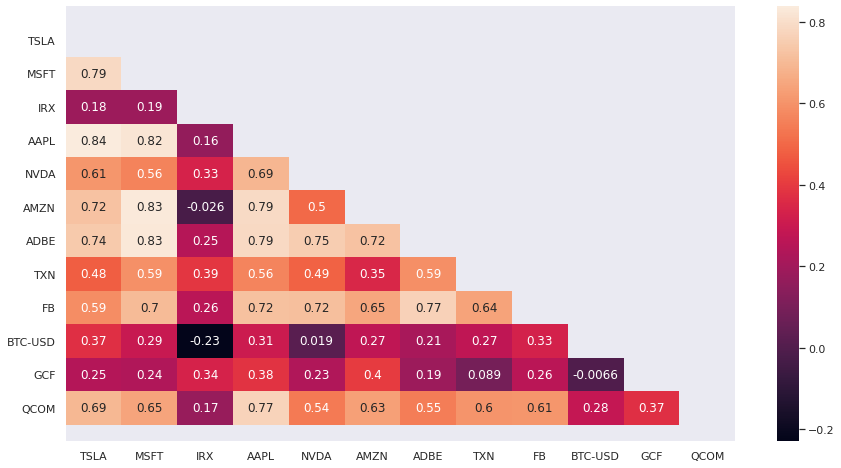

In [7]:
sns.set()
plt.figure(figsize=(15,8))
mask = np.triu(np.ones_like(corr, dtype=bool))
ax = sns.heatmap(data=corr, annot=True, mask=mask)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

## 3. Genetic algorithm setings

We can set the population size and the number of iterations of mating and selection. After running the algorithm we can plot all the results of posible portfolios and the best portfolios considering the biggest expected return, the smallest volatility and the best sharpe ratio.

In [8]:
population_size = 50
n_generations = 100
GA = Genetic_algorithm(monthly_returns, corr_matrix, risk_free, population_size)

In [9]:
variable = 'return'
GA.run(n_generations,variable)
tree1 = GA.get_tree(variable)
analysis1 = GA.get_analysis()
variable = 'volatility'
GA.run(n_generations,variable)
tree2 = GA.get_tree(variable)
analysis2 = GA.get_analysis()
variable = 'sharpe_ratio'
GA.run(n_generations,variable)
tree3 = GA.get_tree(variable)
analysis3 = GA.get_analysis()

In [10]:
result1_df = tree_to_table(tree1, 'tree_1')
result2_df = tree_to_table(tree2, 'tree_2')
result3_df = tree_to_table(tree3, 'tree_3')
results_df = pd.concat([result1_df, result2_df, result3_df])

In [11]:
results_df.sort_values(by = ['return','volatility'], inplace=True, ascending=[False,True])
b1 = results_df.head(1)
results_df

,name,generation,chromosome,return,volatility,sharpe_ratio
2587,tree_1,51,37,7.28,12.369265,0.485073
2600,tree_1,52,0,7.28,12.369265,0.485073
2650,tree_1,53,0,7.28,12.369265,0.485073
2700,tree_1,54,0,7.28,12.369265,0.485073
2750,tree_1,55,0,7.28,12.369265,0.485073
...,...,...,...,...,...,...
2647,tree_3,52,47,1.49,12.344538,0.017012
1432,tree_2,28,32,1.43,10.149565,0.014779
3286,tree_3,65,36,1.43,12.029674,0.012469
4595,tree_2,91,45,1.38,12.526920,0.007983


In [12]:
results_df.sort_values(by = ['volatility','return'], inplace=True, ascending=[True,False])
b2 = results_df.head(1)
results_df

,name,generation,chromosome,return,volatility,sharpe_ratio
94,tree_2,1,44,3.09,5.975597,0.302899
100,tree_2,2,0,3.09,5.975597,0.302899
150,tree_2,3,0,3.09,5.975597,0.302899
200,tree_2,4,0,3.09,5.975597,0.302899
250,tree_2,5,0,3.09,5.975597,0.302899
...,...,...,...,...,...,...
969,tree_1,19,19,2.09,14.879625,0.054437
3861,tree_3,77,11,3.76,15.097550,0.164265
1798,tree_3,35,48,3.71,15.126442,0.160646
1237,tree_1,24,37,3.53,16.000241,0.140623


In [13]:
results_df.sort_values(by='sharpe_ratio', inplace=True, ascending=False)
b3 = results_df.head(1)
results_df

,name,generation,chromosome,return,volatility,sharpe_ratio
4954,tree_1,99,4,7.07,10.437266,0.554743
3404,tree_1,68,4,7.07,10.437266,0.554743
3002,tree_1,60,2,7.07,10.437266,0.554743
3052,tree_1,61,2,7.07,10.437266,0.554743
3102,tree_1,62,2,7.07,10.437266,0.554743
...,...,...,...,...,...,...
2647,tree_3,52,47,1.49,12.344538,0.017012
1432,tree_2,28,32,1.43,10.149565,0.014779
3286,tree_3,65,36,1.43,12.029674,0.012469
4595,tree_2,91,45,1.38,12.526920,0.007983


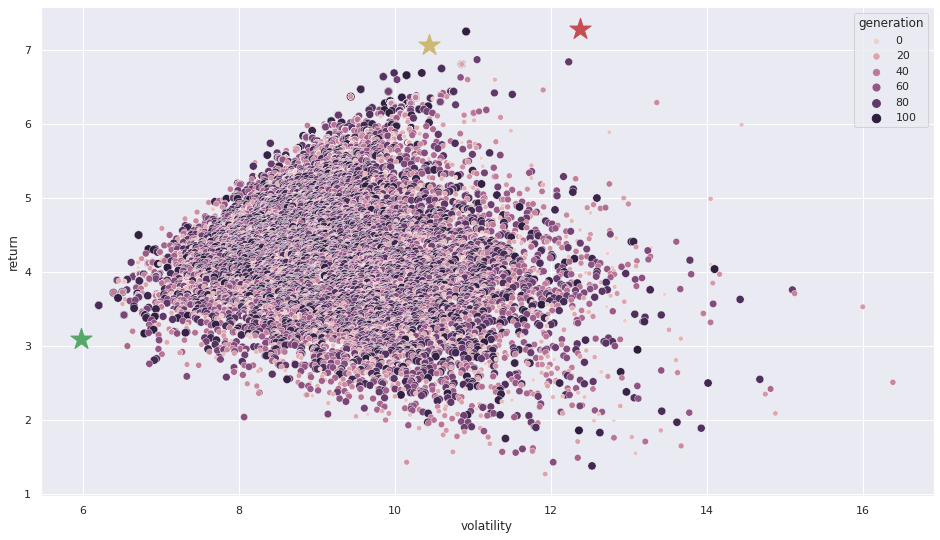

In [14]:
plt.figure(figsize=(16,9))
sns.scatterplot(x = results_df['volatility'],y = results_df['return'], size=results_df['generation'], hue=results_df['generation']) #, style=results_df['name'])
plt.scatter(x = b1['volatility'].iloc[0], y = b1['return'].iloc[0], marker = '*', color = 'r', s =500, label = 'Max E[Retorno]')
plt.scatter(x = b2['volatility'].iloc[0], y = b2['return'].iloc[0], marker = '*', color = 'g', s =500, label = 'Max E[Retorno]')
plt.scatter(x = b3['volatility'].iloc[0], y = b3['return'].iloc[0], marker = '*', color = 'y', s =500, label = 'Max E[Retorno]')

In [15]:
best_portfolios = pd.concat([b1,b2,b3])
best_portfolios

,name,generation,chromosome,return,volatility,sharpe_ratio
2587,tree_1,51,37,7.28,12.369265,0.485073
94,tree_2,1,44,3.09,5.975597,0.302899
4954,tree_1,99,4,7.07,10.437266,0.554743


In [16]:
w1 = tree2[best_portfolios['generation'].iloc[0]][best_portfolios['chromosome'].iloc[0]].get_weights()
w2 = tree2[best_portfolios['generation'].iloc[1]][best_portfolios['chromosome'].iloc[1]].get_weights()
w3 = tree1[best_portfolios['generation'].iloc[2]][best_portfolios['chromosome'].iloc[2]].get_weights()
d = {'stock_name': stock_names, 'Weights_Portafolio_retorno_maximo': w1, 'Weights_Portafolio_volatilidad_minima': w2, 'Weights_Portafolio_sharperatio_optimo': w3}
best_portfolios_weights = pd.DataFrame(data=d)
best_portfolios_weights

,stock_name,Weights_Portafolio_retorno_maximo,Weights_Portafolio_volatilidad_minima,Weights_Portafolio_sharperatio_optimo
0,AAPL,0.000129,2.586992e-03,0.224361
1,ADBE,0.282117,1.030327e-05,0.125838
2,AMZN,0.004779,2.569305e-01,0.000040
3,BTC-USD,0.169582,4.146488e-02,0.000011
4,FB,0.000299,2.932897e-01,0.227047
5,GC=F,0.001914,2.918932e-01,0.154585
6,^IRX,0.077015,2.155780e-07,0.000031
7,MSFT,0.164157,7.014733e-02,0.085983
8,NVDA,0.003255,2.513209e-04,0.005989
9,QCOM,0.062680,4.110337e-02,0.074738


## 4. Results and conclusions

After running the algorithm we obtain three posible portfolios one with the highest expected return, another with the minimun risk and another with the best sharpe ratio, each of this portfolios comes with a list of weights. The list of weights is continuos so it's not useful for the real world, we have to modify it in order to consider the capital available, the actual prices of each stock, the fees, etc. This implementations can be addressed at further work.